# Logistic Regressor
In this notebook we tried a Logistic regressor with Original Mapping quality calculated by vg.

#### Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, roc_curve
from IPython.display import SVG
import os

TRAIN_FILE = "../data/train_gamcompare/csv/compared_mapped100_sim100..csv"
TEST_FILE = "../data/test_gamcompare/csv/tcompared_tmapped100_tsim100..csv"
MODEL_DIR = "../data/models/"
TEST_SVG_DIR = "../data/svgs/test/"
TRAIN_SVG_DIR = "../data/svgs/train/"
TEST_STATS_DIR = "../data/stats/test/"
TRAIN_STATS_DIR = "../data/stats/train/"

VG_DIR = '~/vg' # probably you want to change this

RSCRIPTS_FOLDER = os.path.join(VG_DIR, 'scripts')

def decodePhred(x):
    return 1-10**(-x/10.0)


def encodePhred(x):
    out = -10 * np.log10(1.0000-x)
    out = out.astype(np.int64)
    out[out > 60] = 60
    return out

def output_tsv(df, pred):
    out_df = df.loc[:, ['correct', 'mq', 'aligner', 'read']]
    recal_df =  out_df.copy()
    recal_df.loc[:, 'aligner'] = 'recal'
    recal_df.loc[:, 'mq'] = pred
    
    return out_df.append(recal_df, ignore_index=True)

#### Load Files

In [2]:
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)

In [3]:
train_df.head()

,correct,mq,score,secondary_score,secondary_score_size,identity,aligner,read,mqp,AAAA,...,GCTT,TCTT,AGTT,CGTT,GGTT,TGTT,ATTT,CTTT,GTTT,TTTT
0,1,60,105,105,0,0.99,orig,0be4778ad366b541,0.999999,1,...,0,1,1,0,0,1,0,2,1,1
1,1,60,105,105,7,0.99,orig,7638be6dd4f431e9,0.999999,5,...,1,0,2,0,0,0,0,0,0,0
2,1,60,105,105,0,0.99,orig,aaeea62daae4a15c,0.999999,12,...,0,0,0,0,0,0,1,0,0,1
3,1,60,105,105,0,0.99,orig,10d9f32edb5b3d49,0.999999,3,...,1,1,0,0,0,0,0,0,0,0
4,1,60,100,100,4,0.98,orig,1e85a9c9c73fbd1a,0.999999,0,...,0,0,1,0,1,0,1,0,0,1


In [4]:
train_orig = train_df['mqp'].values
test_orig = test_df['mqp'].values

In [5]:
X_train = train_df['mqp'].values
X_train = X_train.reshape(-1, 1)

In [6]:
X_test = test_df['mqp'].values
X_test =X_test.reshape(-1, 1)

In [7]:
y_train = train_df['correct'].values
y_train = y_train.ravel()

In [8]:
y_test = test_df['correct'].values
y_test = y_test.ravel()

#### Train Logistic Regression

In [9]:
log_reg = LogisticRegression()

In [10]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Evaluate Performance

In [11]:
y_pred_train = log_reg.predict_proba(X_train)

In [12]:
brier_score_loss(y_train, y_pred_train[:, 1]) # Logistic

0.0011341257207227332

In [13]:
brier_score_loss(y_train, train_orig) # Original

0.0017481454421636765

In [14]:
y_pred_test = log_reg.predict_proba(X_test)

In [15]:
brier_score_loss(y_test, y_pred_test[:, 1]) # Logistic

0.00111448771522983

In [16]:
brier_score_loss(y_test, test_orig) # Original

0.0017856050625612286

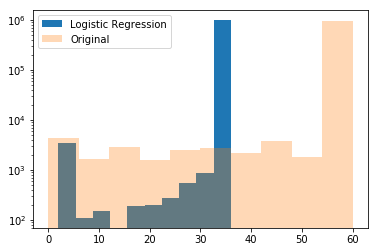

In [17]:
plt.hist(encodePhred(y_pred_train[:, 1]), log=True, label="Logistic Regression")
plt.hist(train_df['mq'], log=True, alpha=0.3, label="Original");
plt.legend();

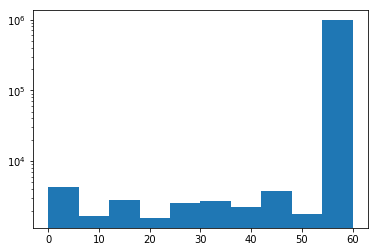

In [18]:
plt.hist(train_df['mq'], log=True);

In [19]:
train_tsv = output_tsv(train_df, encodePhred(y_pred_train[:, 1]))

In [20]:
train_tsv_path = os.path.join(TRAIN_STATS_DIR, "LogReg.tsv")
train_qq_svg_path = os.path.join(TRAIN_SVG_DIR, "qq-Logreg.svg")
train_roc_svg_path = os.path.join(TRAIN_SVG_DIR, "roc-Logreg.svg")
train_tsv.to_csv(train_tsv_path, index=False, sep='\t')

In [21]:
!Rscript {RSCRIPTS_FOLDER}/plot-qq.R {train_tsv_path} {train_qq_svg_path}
!Rscript {RSCRIPTS_FOLDER}/plot-roc.R {train_tsv_path} {train_roc_svg_path}

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: ggrepel
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning messages:
1: Removed 16 rows containing non-finite values (stat_smooth). 
2: Removed 16 rows containing missing values (geom_point). 
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dp

#### TRAIN Q-Q PLOT

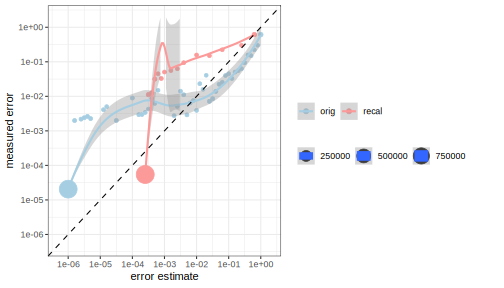

In [22]:
SVG(filename=train_qq_svg_path)

#### TRAIN ROC CURVE

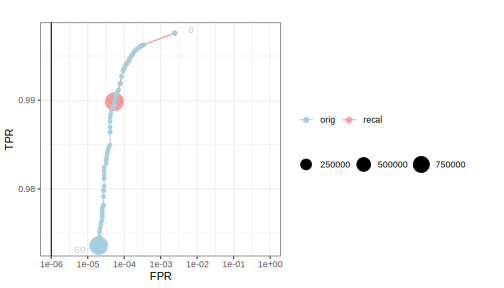

In [23]:
SVG(filename=train_roc_svg_path)

In [24]:
test_tsv = output_tsv(test_df, encodePhred(y_pred_test[:, 1]))

In [25]:
test_tsv_path = os.path.join(TEST_STATS_DIR, "test_LogReg.tsv")
test_qq_svg_path = os.path.join(TEST_SVG_DIR, "qq-Logreg.svg")
test_roc_svg_path = os.path.join(TEST_SVG_DIR, "roc-Logreg.svg")
test_tsv.to_csv(test_tsv_path, index=False, sep='\t')

In [26]:
!Rscript {RSCRIPTS_FOLDER}/plot-qq.R {test_tsv_path} {test_qq_svg_path}
!Rscript {RSCRIPTS_FOLDER}/plot-roc.R {test_tsv_path} {test_roc_svg_path}

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: ggrepel
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning messages:
1: Removed 20 rows containing non-finite values (stat_smooth). 
2: Removed 20 rows containing missing values (geom_point). 
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dp

#### TEST Q-Q plot

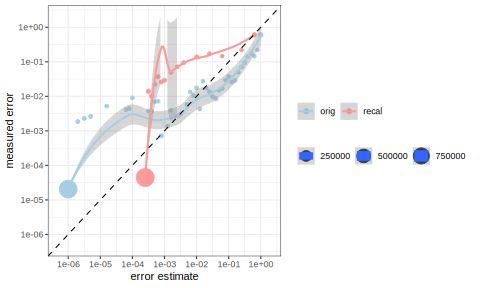

In [27]:
SVG(filename=test_qq_svg_path)

#### TEST ROC CURVE

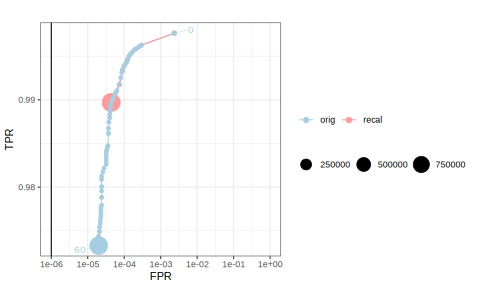

In [28]:
SVG(filename=test_roc_svg_path)